In [ ]:
#install the nltools module
!pip install nltools
!pip install pingouin


In [ ]:
#install all modules required to perform ISC, IS-RSA, functional hyperalignment analyses
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length, fisher_r_to_z, correlation_permutation
from nilearn.plotting import view_img_on_surf, view_img, plot_glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp, rankdata, ttest_rel
from scipy.signal import hilbert
from sklearn.manifold import TSNE
import networkx as nx
from IPython.display import HTML
from nilearn import plotting
from nilearn import signal
from nilearn import regions
import nibabel as nib


/usr/local/lib/python3.7/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Load the NARSAD timeseries

In [ ]:
#read the timeseries of all neurotypical youths and adolescents suffering from depressive symptoms into a 3D array

data_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/NARSAD3/*_task-thepresent_nuisance_regressed_shen_2mm_268.txt'))
sub_list = [os.path.basename(x).split('_')[0] for x in data_dir]

timeseries = []
sub_timeseries = {}

for filename in data_dir:

  shen = np.loadtxt(filename)
  shen_df = pd.DataFrame(shen)
  shen_df.reset_index(inplace = True, drop = True)
  shen_df_to_array = shen_df.to_numpy()
  timeseries.append(shen_df_to_array)

timeseries_3D = np.array(timeseries)


In [ ]:
#convert the timeseries of all participants to a dataframe

timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  timeseries_reg[sub] = pd.DataFrame(timeseries_3D[sub, :, :])
  

In [ ]:
#standardise the timeseries by z-transforming the timesries and store it in a dataframe

standardise_df = {}
timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  standardise_df[sub] = signal.clean(timeseries_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  timeseries_reg[sub] = pd.DataFrame(standardise_df[sub])


### Load the Shen (k = 268) Parcellation

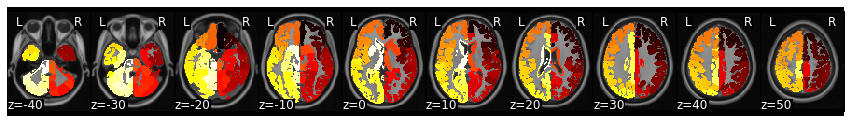

In [ ]:
#load the Shen 268 parcellation as a mask
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
mask.plot()


### Extract subject-wise timeseries for each ROI

In [ ]:
#extract the subject-wise timeseries for each ROI

roi = 240
#mask_x[roi].plot()

def get_subject_roi(data, roi):

    sub_rois = {}

    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

sub_rois = get_subject_roi(timeseries_reg, roi)
sub_rois


### Tapered Cosine Sliding Window

Text(0.5, 0, 'Sample')

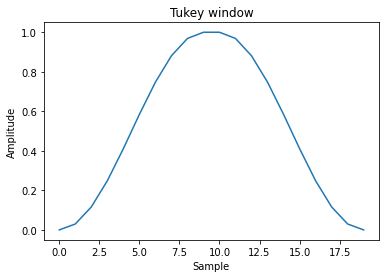

In [ ]:
#compute the weights from a tapered cosine sliding window (Tukey window) as described by Gruskin et al., 2020

from scipy import signal
window = signal.windows.tukey(20, alpha = 0.95, sym = True)
plt.plot(window)
plt.title("Tukey window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")


### Dynamic ISC using Sliding Window (width = 20 TR)

In [ ]:
#initialise number of subjects, timepoints and regions
n_subs, tp, nodes = timeseries_3D.shape

#initialise number of sliding windows to compute dynamic ISC
num_window = tp - window.shape[0]

#initialise TR with a step size of 1 which is consistent with Gruskin et al. (2020)
TR = np.arange(0, 20, 1)

#initialise the sliding timeseries
weighted_timeseries, slid_win_timeseries = np.zeros((n_subs, nodes, len(TR))), {}

#compute ISC across the whole-brain (i.e. for 268 ROIs) using the subject-wise bootstrap method set at 5K iterations
isc_r, isc_p = {}, {}
isc_win_r, isc_win_p = {}, {}

for sliding in range(0, 20):
  
  print(sliding)

  for sub in range(n_subs):
    
    for roi in range(nodes):

      #compute the weighted timeseries by multiplying the timeseries with the tapered cosine sliding window
      weighted = timeseries_reg[sub][min(TR):max(TR) + 1][roi] * window
      weighted_timeseries[sub, roi,:] = weighted

  for sub in range(weighted_timeseries.shape[0]):
    
    #transpose the dictionary from (268, 20) to (20, 268) for each subject
    slid_win_timeseries[sub] = pd.DataFrame(weighted_timeseries[sub, :, :]).T
  
  for roi in range(nodes):

    #compute ISC for each roi and sliding window using the boostrap approach over 5K iterations
    stats = isc(get_subject_roi(slid_win_timeseries, roi), n_bootstraps = 5000, metric = 'median', method = 'bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
  
  #store all the ISC and their p-values for each sliding window and roi
  isc_win_r[sliding], isc_win_p[sliding] = pd.DataFrame([isc_r]), pd.DataFrame([isc_p])

  TR += 1
  print(TR)


### Parellel Dynamic ISC

In [ ]:
y = {}

for i in range(0, 20):

  y[i] = isc_win_r[i].squeeze().to_dict()


In [ ]:
z = {}

for j in range(0, 20):

  z[j] = isc_win_p[j].squeeze().to_dict()


In [ ]:
import json
isc_win_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_0_20_r_value_window_fullmovie.json", "w")
json.dump(y, isc_win_r_file)
isc_win_r_file.close()


In [ ]:
isc_win_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_0_20_p_value_window_fullmovie.json", "w")
json.dump(z, isc_win_p_file)
isc_win_p_file.close()


In [ ]:
import json

window_0_20_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_0_20_r_value_window_fullmovie.json", "r")
R_0_20 = json.loads(window_0_20_r_file.read())

window_0_20_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_0_20_p_value_window_fullmovie.json", "r")
P_0_20 = json.loads(window_0_20_p_file.read())

window_20_40_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_20_40_r_value_window_fullmovie.json", "r")
R_20_40 = json.loads(window_20_40_r_file.read())

window_20_40_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_20_40_p_value_window_fullmovie.json", "r")
P_20_40 = json.loads(window_20_40_p_file.read())

window_40_60_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_40_60_r_value_window_fullmovie.json", "r")
R_40_60 = json.loads(window_40_60_r_file.read())

window_40_60_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_40_60_p_value_window_fullmovie.json", "r")
P_40_60 = json.loads(window_40_60_p_file.read())

window_60_80_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_60_80_r_value_window_fullmovie.json", "r")
R_60_80 = json.loads(window_60_80_r_file.read())

window_60_80_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_60_80_p_value_window_fullmovie.json", "r")
P_60_80 = json.loads(window_60_80_p_file.read())

window_80_100_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_80_100_r_value_window_fullmovie.json", "r")
R_80_100 = json.loads(window_80_100_r_file.read())

window_80_100_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_80_100_p_value_window_fullmovie.json", "r")
P_80_100 = json.loads(window_80_100_p_file.read())

window_100_112_r_file = open("/content/drive/MyDrive/Year2/dISC3/data_100_112_r_value_window_fullmovie.json", "r")
R_100_112 = json.loads(window_100_112_r_file.read())

window_100_112_p_file = open("/content/drive/MyDrive/Year2/dISC3/data_100_112_p_value_window_fullmovie.json", "r")
P_100_112 = json.loads(window_100_112_p_file.read())

isc_sliding_r = {**R_0_20, **R_20_40, **R_40_60, **R_60_80, **R_80_100, **R_100_112}
isc_sliding_p = {**P_0_20, **P_20_40, **P_40_60, **P_60_80, **P_80_100, **P_100_112}


### Dynamic ISC Spatial Maps

In [ ]:
isc_window_r_df = pd.DataFrame(isc_sliding_r)
isc_window_p_df = pd.DataFrame(isc_sliding_p)

for window in range(isc_window_r_df.shape[1]):

  rval = isc_window_r_df.iloc[:, window]
  rval.to_dict()
  
  pval = isc_window_p_df.iloc[:, window]
  pval.to_dict()
  
  fdr_thr = fdr(pd.Series(pval).values)

  isc_r_sliding_brain, isc_p_sliding_brain = roi_to_brain(pd.Series(rval), mask_x), roi_to_brain(pd.Series(pval), mask_x)
  plotting.plot_glass_brain(threshold(isc_r_sliding_brain, isc_p_sliding_brain, thr = fdr_thr).to_nifti(), colorbar = True, plot_abs = False, display_mode = 'lyrz', cmap = 'RdBu_r')
  
  isc_r_sliding_brain.write("/content/drive/MyDrive/Year2/FullMovie_dISCMap/ISC_map"+str(window)+".nii.gz")


### Explained Variance of Independent Components

[Memory]1113.3s, 18.6min: Loading explained_variance from nilearn_cache/joblib/nilearn/decomposition/base/explained_variance/1034f6c2d0fa83b9c072105802c451a1
__________________________________explained_variance cache loaded - 0.0s, 0.0min


Text(0.5, 0, 'Component #')

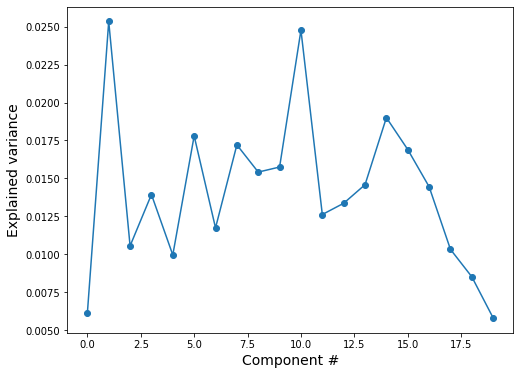

In [ ]:
scores = canica.score(result_img, per_component = True)
plt.figure(figsize = (8, 6))
plt.plot(scores, '-o')
plt.ylabel('Explained variance', size = 14)
plt.xlabel('Component #', size = 14)


### Extract timeseries of Independent Components

In [ ]:
t1 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t1.txt')
t2 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t2.txt')
t3 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t3.txt')
t4 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t4.txt')
t5 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t5.txt')
t6 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t6.txt')
t7 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t7.txt')
t8 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t8.txt')
t9 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t9.txt')
t10 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t10.txt')
t11 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t11.txt')
t12 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t12.txt')
t13 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t13.txt')
t14 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t14.txt')
t15 = np.loadtxt('/content/drive/MyDrive/Year2/dISC3_TS/t15.txt')

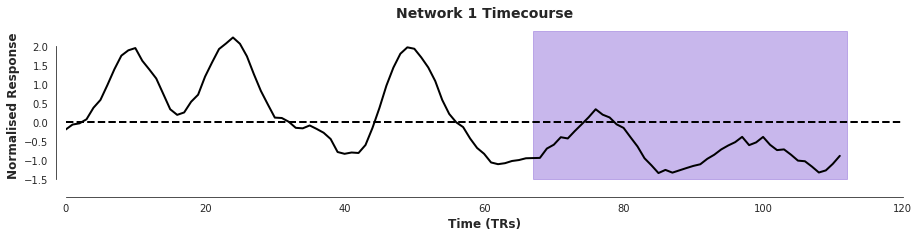

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t1, color = 'black', linewidth = '2')
plt.title('Network 1 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -4.82e-13, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC1_timecourse.png')


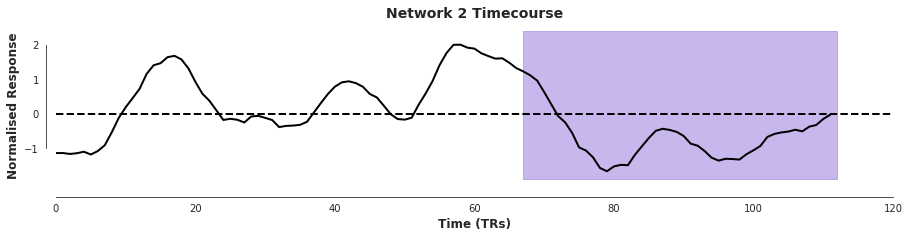

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t2, color = 'black', linewidth = '2')
plt.title('Network 2 Timecourse', fontweight = 'bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight = 'bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -7.46e-12, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.9, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC2_timecourse.png')


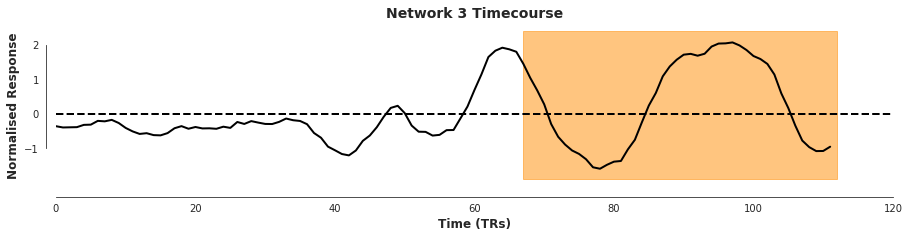

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t3, color = 'black', linewidth = '2')
plt.title('Network 3 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = 3.17e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.9, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='darkorange', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC3_timecourse.png')


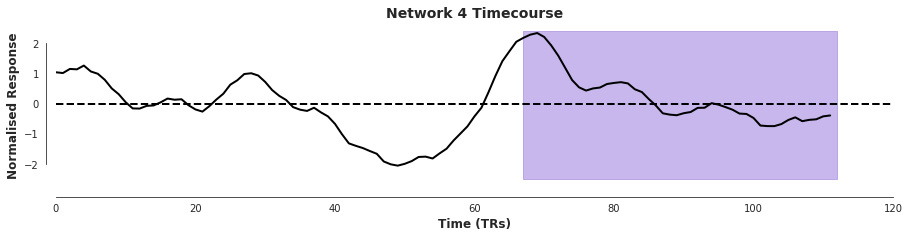

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t4, color = 'black', linewidth = '2')
plt.title('Network 4 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -1.75e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC4_timecourse.png')


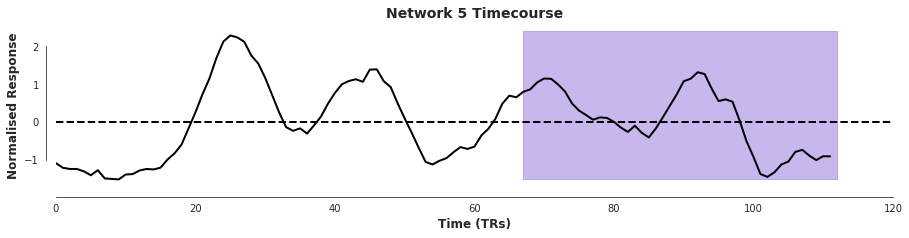

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t5, color = 'black', linewidth = '2')
plt.title('Network 5 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0,120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -2.26e-12, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC5_timecourse.png')


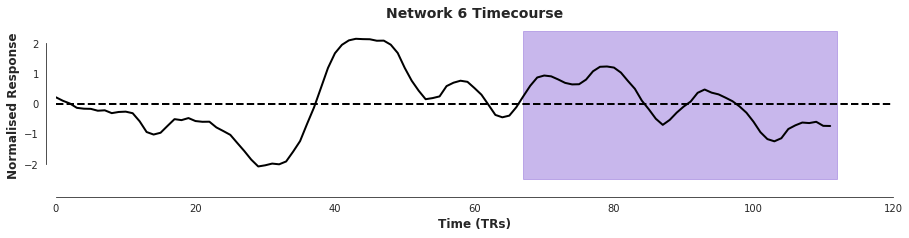

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t6, color = 'black', linewidth = '2')
plt.title('Network 6 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -1.68e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC6_timecourse.png')


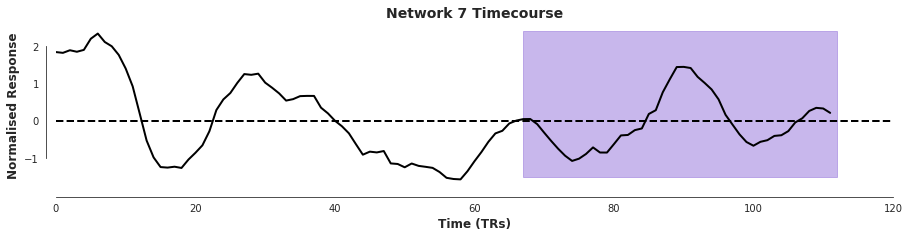

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t7, color = 'black', linewidth = '2')
plt.title('Network 7 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = 3.46e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC7_timecourse.png')


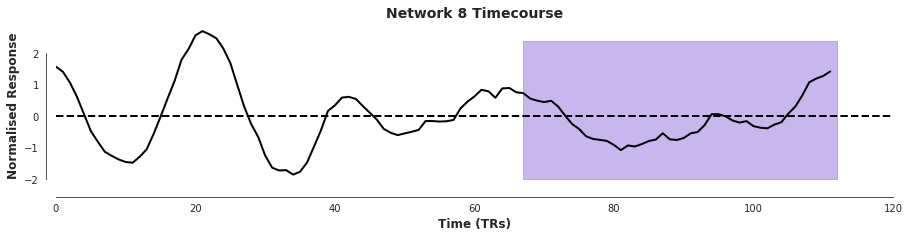

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t8, color = 'black', linewidth = '2')
plt.title('Network 8 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = 6.31e-12, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.0, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC8_timecourse.png')


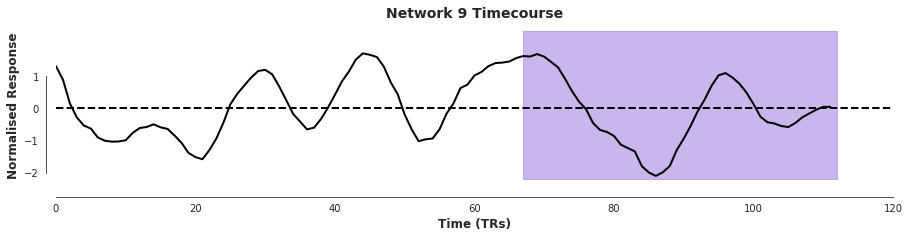

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t9, color = 'black', linewidth = '2')
plt.title('Network 9 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -3.13e-12, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.2, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC9_timecourse.png')


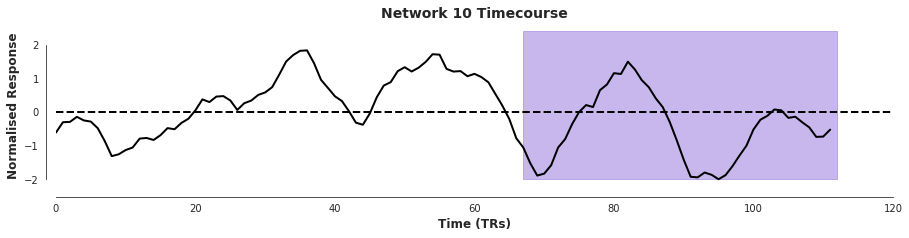

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t10, color = 'black', linewidth = '2')
plt.title('Network 10 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = 2.31e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.0, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC10_timecourse.png')


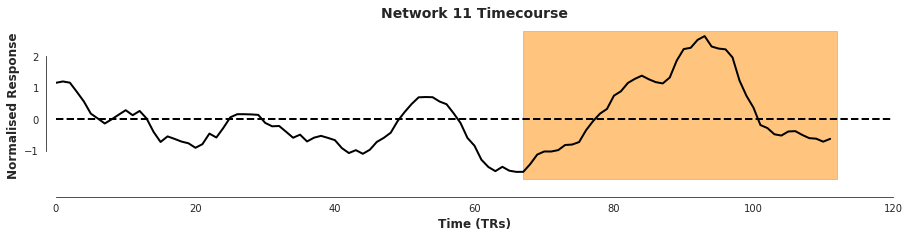

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t11, color = 'black', linewidth = '2')
plt.title('Network 11 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -1.98e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.9, 2.9, 0.1)
plt.fill_betweenx(y, 67, 112, color ='darkorange', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC11_timecourse.png')


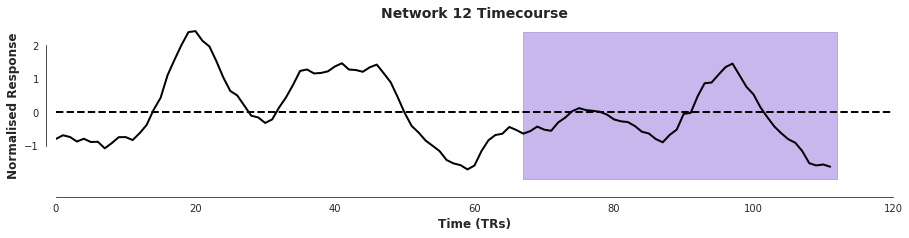

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t12, color = 'black', linewidth = '2')
plt.title('Network 12 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0,120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -2.44e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.0, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC12_timecourse.png')


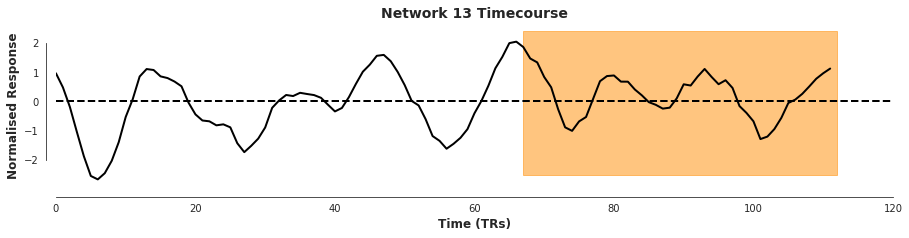

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t13, color = 'black', linewidth = '2')
plt.title('Network 13 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -1.47e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='darkorange', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC12_timecourse.png')


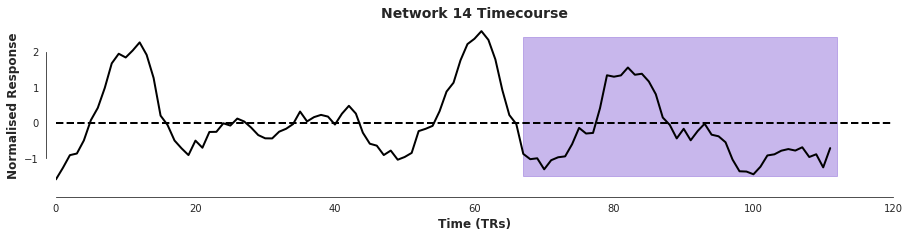

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t14, color = 'black', linewidth = '2')
plt.title('Network 14 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -1.74e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-1.5, 2.5, 0.1)
plt.fill_betweenx(y, 67, 112, color ='mediumpurple', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC12_timecourse.png')


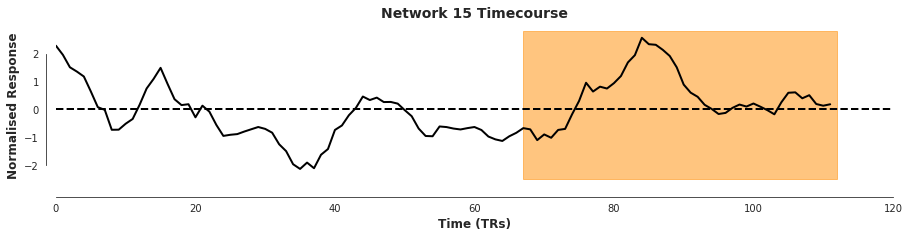

In [ ]:
plt.figure(figsize=(15,3))
sns.set_style("white")
plt.plot(t15, color = 'black', linewidth = '2')
plt.title('Network 15 Timecourse', fontweight ='bold', fontsize = 14)
plt.xlabel('Time (TRs)', fontweight ='bold', fontsize = 12)
plt.ylabel('Normalised Response', fontweight ='bold', fontsize = 12)
plt.xlim(0, 120)
sns.despine(offset = 10, trim = True)
plt.axhline(y = -1.82e-11, linewidth = 2, ls = '--', color = 'black')

y = np.arange(-2.5, 2.9, 0.1)
plt.fill_betweenx(y, 67, 112, color ='darkorange', alpha = 0.5)

#plt.savefig('/content/drive/MyDrive/Year2/ICMap/IC12_timecourse.png')


### Relationship between dynamic ISC and BDI-Y/CERQ scores

In [ ]:
data_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/ICTS2/IC14/*_mean_TS_IC14.txt'))
sub_list = [os.path.basename(x).split('_')[0] for x in data_dir]

timeseries = []
sub_timeseries = {}

for filename in data_dir:

  shen = np.loadtxt(filename)
  shen_df = pd.DataFrame(shen)
  shen_df.reset_index(inplace = True, drop = True)
  shen_df_to_array = shen_df.to_numpy()
  timeseries.append(shen_df_to_array)

timeseries_3D = np.array(timeseries)


In [ ]:
#convert the timeseries of all participants to a dataframe

timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  timeseries_reg[sub] = pd.DataFrame(timeseries_3D[sub, :, :])


In [ ]:
#standardise the timeseries by z-transforming the timesries and store it in a dataframe

standardise_df = {}
timeseries_reg = {}

for sub in range(timeseries_3D.shape[0]):

  standardise_df[sub] = signal.clean(timeseries_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False)
  timeseries_reg[sub] = pd.DataFrame(standardise_df[sub])


In [ ]:
#extract the subject-wise timeseries for each ROI

def get_subject_roi(data, roi):

    sub_rois = {}

    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

sub_rois = get_subject_roi(timeseries_reg, roi)
sub_rois.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.338984,1.345918,0.909338,-1.214250,-0.110571,0.292296,-1.259280,-0.951771,-1.713088,-1.455319,0.557668,-0.253912,0.037159,-1.227525,0.494064,-1.150647,-1.526843,-2.024719,-0.810327,-0.837141,-2.348335,-1.775188,-0.077642,-0.655783,-0.157691,-1.073181,-1.143872,0.766055,0.174135,-0.967006,0.108950,-2.578177,-0.810604,-1.943427,0.147355,-1.599030,-0.780847,-1.737529,-0.009264,-0.667155,-0.176596,-0.225564,-1.655585,0.889349,1.094262,1.104006,0.763965,0.222627,-1.592556,-1.598857
1,-0.357625,0.286049,0.329362,-0.296010,0.251154,0.703640,-2.060223,-0.752883,-1.317682,-1.490146,0.303326,0.369063,-0.506230,-1.025764,0.031883,-1.678944,-0.566192,-2.240811,0.176917,-1.131737,-2.784951,-1.460687,-0.377340,-0.679566,0.576424,-0.759331,-1.271802,1.817213,0.510705,-1.278346,0.716699,-2.462372,-0.742720,-2.884919,-0.246564,-1.968584,-1.234681,-2.001140,0.183169,-0.575467,0.448459,-0.047682,-1.420354,0.915351,0.647799,0.830236,0.830358,-0.232236,-1.072235,-2.284491
2,-1.102216,-1.446935,-0.465439,0.936170,0.497695,0.737212,-1.715458,0.067307,-0.316374,-0.900843,-0.518786,0.638350,-1.478381,-0.633724,-0.589296,-1.621902,0.904831,-1.729736,0.991318,-1.480283,-2.176985,-0.484901,-1.278308,-0.098897,0.353488,0.179086,-1.016748,1.685158,0.900035,-1.276584,0.998501,-1.167303,-0.505764,-2.962571,-1.021401,-1.639132,-1.085543,-1.472027,0.477352,-0.836787,0.531185,-0.264683,-0.572748,-0.175709,-0.370527,-0.159597,0.258237,-0.810719,-0.617018,-2.364176
3,-2.036803,-2.772739,-1.091494,1.208616,0.537755,0.273926,-0.384758,1.104526,0.554485,-0.383999,-1.187699,0.494184,-2.244144,-0.295653,-1.065282,-0.737224,1.626596,-0.874432,1.108105,-1.836670,-1.024068,0.532913,-2.150378,0.946341,-0.926604,1.140581,-0.625656,0.576906,1.258764,-1.022379,0.683206,0.401166,-0.276397,-1.795765,-1.393909,-0.906061,-0.154189,-0.583397,0.826871,-1.003843,0.063534,-0.735550,0.220921,-1.547958,-1.188961,-1.187818,-0.778767,-0.989196,-0.570685,-1.729604
4,-2.038944,-2.881812,-1.356078,0.175976,0.318975,-0.382056,0.810590,1.702995,0.833633,-0.456423,-0.969210,0.473904,-2.000358,-0.046663,-1.124465,0.505340,1.028585,-0.056118,0.654003,-1.846199,0.019729,1.075704,-2.017580,1.852999,-2.090575,1.686320,-0.413150,-0.387825,1.455334,-0.547483,0.021780,1.183394,0.029833,0.063409,-0.929387,-0.127330,1.026286,-0.145686,1.002076,-0.474488,-0.272792,-0.963648,0.553512,-1.855507,-1.167615,-1.460881,-1.584336,-0.460074,-0.688637,-0.793458


In [ ]:
#compute ISC across the whole-brain (i.e. for 268 ROIs) using the subject-wise bootstrap method set at 5K iterations

isc_r, isc_p = {}, {}

for roi in range(timeseries_3D.shape[2]):
    
    stats = isc(get_subject_roi(timeseries_reg, roi), n_bootstraps = 5000, metric = 'median', method = 'bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
    

Text(0.5, 1.0, 'Similarity Matrix')

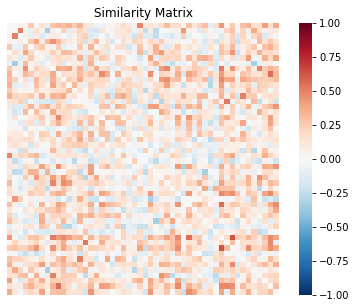

In [ ]:
timeseries_IC = np.squeeze(timeseries_3D)
pair_sim_matrix = Adjacency(1 - pairwise_distances(timeseries_IC, metric='correlation'), matrix_type='Similarity')
pair_sim_matrix.plot(cmap='RdBu_r', vmin = -1, vmax = 1, xticklabels = False, yticklabels = False, )
plt.title('Similarity Matrix')


In [ ]:
similarity_matrix = pair_sim_matrix.squareform()
mean_isc = np.zeros((timeseries_IC.shape[0]))

for sub in range(timeseries_IC.shape[0]):
  
  corr_matrix = similarity_matrix[sub, :]
  corr_matrix_nondiag = np.delete(corr_matrix, sub)
  mean_isc[sub] = np.mean(corr_matrix_nondiag)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


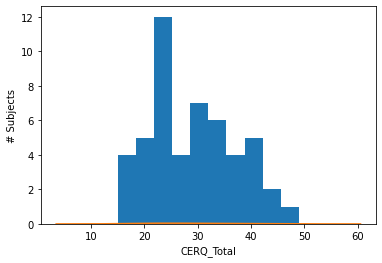

In [ ]:
#load the behavioural measures: (1) BDI-Y which assessed the severity of depressive symptoms in youths - (2) CERQ which measured the cognitive emotional regulation in adolescents

behav_data_BDI = pd.read_csv('/content/drive/MyDrive/Year2/behav_narsad_data.csv', index_col= "SubjectID")
behav_data_CERQ = pd.read_csv('/content/drive/MyDrive/Year2/maladaptive_strategy_CERQ.csv')

behav = behav_data_CERQ["CERQ_Total"]
plt.hist(behav)
plt.xlabel('BDI-Y Scores')
plt.ylabel('# Subjects')
sns.distplot(behav)


In [ ]:
#compute the relationship between mean ISC and behavioural measures with Spearman's Rank using the permutation method set at 5K iterations
stats = correlation_permutation(mean_isc, behav, method = 'permute', n_permute = 5000, metric = 'spearman', n_jobs = -1, return_perms = False, random_state = None)
stats

{'correlation': -0.0029801976344402104, 'p': 0.9842031593681264}